In [267]:
import pandas as pd
from streamlit_assets.components import get_recos_users, filter_reviews
from sklearn.preprocessing import LabelEncoder
from surprise import SVD, NMF, KNNBasic, SVDpp
from surprise.model_selection import cross_validate
from surprise import Dataset
from surprise import Reader
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS


### Exploring metacritic data for recos

In [11]:
meta_df = pd.read_csv('data/metacritic.csv').dropna(subset='critic_meta_score')
#meta_df = meta_df.rename(columns={"title":"item_id"})

meta_df.head()


,title,rank,critic_meta_score,review_content,review_source,author,review_date,summary,meta_score,user_score,release_date,link,critics_reviews_link
0,Rectify: Season 4,1,100.0,It allows us to know and care for these charac...,Collider,Allison Keene,"Oct 27, 2016",Daniel tries to start a new life outside of Pa...,99,8.7,"October 26, 2016",https://www.metacritic.com/tv/rectify/season-4,https://www.metacritic.com/tv/rectify/season-4...
1,Rectify: Season 4,1,100.0,"Rectify, a drama entering its final season on ...",The New York Times,James Poniewozik,"Oct 25, 2016",Daniel tries to start a new life outside of Pa...,99,8.7,"October 26, 2016",https://www.metacritic.com/tv/rectify/season-4,https://www.metacritic.com/tv/rectify/season-4...
2,Rectify: Season 4,1,100.0,No other series so poignantly probes the human...,Salon,Melanie McFarland,"Oct 26, 2016",Daniel tries to start a new life outside of Pa...,99,8.7,"October 26, 2016",https://www.metacritic.com/tv/rectify/season-4,https://www.metacritic.com/tv/rectify/season-4...
3,Rectify: Season 4,1,100.0,None of these characters is particularly happy...,Yahoo TV,Ken Tucker,"Oct 26, 2016",Daniel tries to start a new life outside of Pa...,99,8.7,"October 26, 2016",https://www.metacritic.com/tv/rectify/season-4,https://www.metacritic.com/tv/rectify/season-4...
4,Rectify: Season 4,1,100.0,Rectify is the best series I have ever seen on...,The Daily Beast,Malcolm Jones,"Oct 26, 2016",Daniel tries to start a new life outside of Pa...,99,8.7,"October 26, 2016",https://www.metacritic.com/tv/rectify/season-4,https://www.metacritic.com/tv/rectify/season-4...


In [262]:
meta_df['tv_show'] = meta_df['title'].str.split(': Season').str[0]
meta_df.head()

,title,rank,critic_meta_score,review_content,review_source,author,review_date,summary,meta_score,user_score,release_date,link,critics_reviews_link,title_group,user_id,item_id,rating,tv_show
0,Rectify: Season 4,1,100.0,It allows us to know and care for these charac...,Collider,Allison Keene,"Oct 27, 2016",Daniel tries to start a new life outside of Pa...,99,8.7,"October 26, 2016",https://www.metacritic.com/tv/rectify/season-4,https://www.metacritic.com/tv/rectify/season-4...,Rectify,8,Rectify: Season 4,100,Rectify
1,Rectify: Season 4,1,100.0,"Rectify, a drama entering its final season on ...",The New York Times,James Poniewozik,"Oct 25, 2016",Daniel tries to start a new life outside of Pa...,99,8.7,"October 26, 2016",https://www.metacritic.com/tv/rectify/season-4,https://www.metacritic.com/tv/rectify/season-4...,Rectify,55,Rectify: Season 4,100,Rectify
7,Rectify: Season 4,1,100.0,"Season 4, which marks the all-too-soon end of“...",IndieWire,Ben Travers,"Oct 24, 2016",Daniel tries to start a new life outside of Pa...,99,8.7,"October 26, 2016",https://www.metacritic.com/tv/rectify/season-4,https://www.metacritic.com/tv/rectify/season-4...,Rectify,19,Rectify: Season 4,100,Rectify
21,The Larry Sanders Show: Season 4,2,90.0,As cheerfully goofy and bizarrely on target as...,The New York Times,John J. O'Connor,"Jul 17, 2013",Comic Garry Shandling draws upon his own talk ...,99,5.8,"July 19, 1995",https://www.metacritic.com/tv/the-larry-sander...,https://www.metacritic.com/tv/the-larry-sander...,The Larry Sanders Show,64,The Larry Sanders Show: Season 4,90,The Larry Sanders Show
47,Murder One: Season 1,3,80.0,It's by no means assured that American viewers...,The New York Times,John J. O'Connor,"Jan 29, 2014",One of several crime and law dramas created by...,99,6.4,"September 19, 1995",https://www.metacritic.com/tv/murder-one/season-1,https://www.metacritic.com/tv/murder-one/seaso...,Murder One,64,Murder One: Season 1,80,Murder One


In [230]:
meta_df['review_source'].unique()

array(['Collider', 'The New York Times', 'Salon', 'Yahoo TV',
       'The Daily Beast', 'Vox.com', 'Hitfix', 'IndieWire',
       'Slant Magazine', 'Boston Herald', 'TV Guide Magazine',
       'Chicago Tribune', 'Philadelphia Inquirer', 'USA Today',
       'Baltimore Sun', 'Entertainment Weekly', 'New York Daily News',
       'Chicago Sun-Times', 'Los Angeles Times', 'Orlando Sentinel',
       'Newsday', 'Houston Chronicle', 'Variety', 'Boston Globe',
       'San Diego Union-Tribune', 'People Weekly',
       'Philadelphia Daily News', 'Dallas Morning News',
       'Cleveland Plain Dealer', 'Pittsburgh Post-Gazette',
       'San Jose Mercury News/Contra Costa Times',
       'St. Louis Post-Dispatch', 'Kansas City Star', 'Washington Post',
       'Newark Star-Ledger', 'The New Yorker', 'The Huffington Post',
       'The Hollywood Reporter', 'San Francisco Chronicle', 'Uncle Barky',
       'New York Post', 'Denver Post', 'Time', 'Newsweek',
       'Arizona Republic', 'Detroit Free Press', 

In [256]:
# option to filter critics
critic_list = ['Collider', 'The New York Times','IndieWire','Consequence','The A.V. Club']
mask = meta_df['review_source'].isin(critic_list)
meta_df = meta_df[mask]

In [257]:
id_maker = LabelEncoder()
meta_df['user_id'] = id_maker.fit_transform(meta_df['author'])
meta_df['item_id'] = meta_df['title']
meta_df['rating'] = meta_df['critic_meta_score'].apply(int)

reviews = meta_df[['user_id','item_id','rating']]


In [258]:
tv_list = ['Breaking Bad: Season 5',
           'Rectify: Season 4',
           'Better Call Saul: Season 5',
           'The Leftovers: Season 1',
           'Lodge 49',
           'The Underground Railroad',
           'Master of None: Season 1',
           'Normal People: Season 1',
           'Fleabag: Season 1'
          ]


In [263]:
df_recos = get_recos_users(tv_list,reviews, filter_items=False,filter_n=10, default_rating=90)

C:\git\reco_system\streamlit_assets\components.py:82: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [264]:
df_merged = df_recos.merge(meta_df, on='item_id').drop_duplicates(subset='item_id')
df_merged['difference'] = df_merged['user match'] - df_merged['meta_score']
df_merged[['title','summary','user match','meta_score','rank','difference']].head(30).sort_values(by='user match', ascending = False)

,title,summary,user match,meta_score,rank,difference
30,Fleabag: Season 2,A priest (Andrew Scott) helps Fleabag change t...,89.148586,96,25,-6.851414
14,Atlanta: Season 2,The second season subtitled the Atlanta Robbin...,89.068988,97,15,-7.931012
39,The Americans: Season 4,Elizabeth and Phillips are given a new dangero...,88.360067,95,31,-6.639933
5,The Leftovers: Season 3,The third and final season of the Damon Lindel...,87.899834,98,9,-10.100166
18,America to Me: Season 1,The 10-part documentary series from Steve Jame...,87.210513,96,17,-8.789487
44,Better Things: Season 3,Co-creator/writer/star Pamela Adlon will again...,86.908685,94,34,-7.091315
27,Better Things: Season 2,All 10 episodes of the second season of the fa...,85.968286,96,24,-10.031714
51,Barry: Season 3,Barry finds it's not just other people stoppin...,85.833290,94,38,-8.166710
12,Planet Earth: Blue Planet II,"Airing simultaneously on AMC, BBC America, IFC...",84.478797,97,14,-12.521203
35,Planet Earth II: Season 1,"Narrated by David Attenborough, the sequel to ...",84.071769,96,27,-11.928231


In [265]:
df_grouped = df_merged.groupby('tv_show').mean()

In [266]:
df_grouped[['user match','meta_score','difference','rank']].sort_values(by='user match', ascending = False).head(20)

,user match,meta_score,difference,rank
tv_show,,,,
Fleabag,89.148586,96.000000,-6.851414,25.000000
A Parks and Recreation Special,87.414614,89.000000,-1.585386,124.000000
America to Me,87.210513,96.000000,-8.789487,17.000000
Atlanta,86.690394,92.666667,-5.976273,60.333333
Howards End,86.583375,86.000000,0.583375,204.000000
I Think You Should Leave with Tim Robinson,86.075373,87.000000,-0.924627,175.000000
It's a Sin,85.893220,91.000000,-5.106780,77.000000
City So Real,85.691162,93.000000,-7.308838,45.000000
Red Oaks,85.530368,70.000000,15.530368,1241.000000


### Now, looking at trends between Metacritic rank and our SVD recommendation scores

In [253]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Season by Season data","Grouped by TV Show Data"))

fig.append_trace(list(px.scatter(df_merged, x='rank', y='user match',trendline = "ols",trendline_color_override="red", height = 350).select_traces())[0],
                           row=1, col=1)
fig.append_trace(list(px.scatter(df_merged, x='rank', y='user match',trendline = "ols",trendline_color_override="red", height = 350).select_traces())[1],
                           row=1, col=1)
fig.append_trace(list(px.scatter(df_grouped, x='rank', y='user match',trendline = "ols",trendline_color_override="red", height = 350).select_traces())[0],
                           row=1, col=2)
fig.append_trace(list(px.scatter(df_grouped, x='rank', y='user match',trendline = "ols",trendline_color_override="red", height = 350).select_traces())[1],
                           row=1, col=2)
fig.show()

### What do we see?
- The Score is very proportional to the rank, which is not great because we would want recommendations not be only a mere reflection of the meta score/rank, but also to capture an idiosyncratic component based on our preferences
- However, for extreme values, and most interestingly for high ranks, which are the most likely recommendations, the linear relationship seems to break down


In [254]:
df_merged_top = df_merged.sort_values(by='meta_score',ascending=False).reset_index().head(100) #top 100 seasons
df_grouped_top = df_grouped.sort_values(by='meta_score',ascending=False).reset_index().head(100) #top 100 shows

In [255]:
fig2 = make_subplots(rows=1, cols=2, subplot_titles=("Top 100 Seasons","Top 100 Shows"))

fig2.append_trace(list(px.scatter(df_merged_top, x='rank', y='user match',trendline = "ols",trendline_color_override="red", height = 350).select_traces())[0],
                           row=1, col=1)
fig2.append_trace(list(px.scatter(df_merged_top, x='rank', y='user match',trendline = "ols",trendline_color_override="red", height = 350).select_traces())[1],
                           row=1, col=1)
fig2.append_trace(list(px.scatter(df_grouped_top, x='rank', y='user match',trendline = "ols",trendline_color_override="red", height = 350).select_traces())[0],
                           row=1, col=2)
fig2.append_trace(list(px.scatter(df_grouped_top, x='rank', y='user match',trendline = "ols",trendline_color_override="red", height = 350).select_traces())[1],
                           row=1, col=2)
fig2.show()

### Much better! OLS R²'s have dropped

### Wordcloud

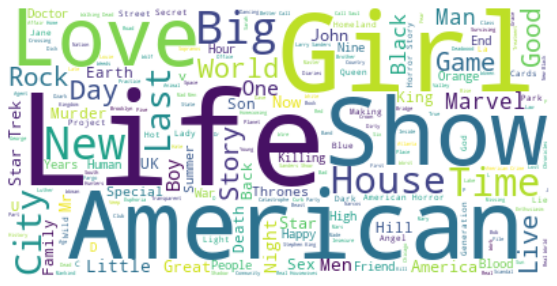

In [274]:
text = " ".join(i for i in df_merged['title'])
stopwords = list(set(STOPWORDS))+['Season','1','2','3','4','5','6','7']
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()